In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 1000)

import requests
import pandas as pd
from bs4 import BeautifulSoup

from team_map import team_map

In [2]:
seasons = [2015, 2016, 2017, 2018, 2019]
weeks = [str(w) for w in range(1, 18)]
pbp_url = 'https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_'
weather_url = 'http://www.nflweather.com/en/week/'

In [3]:
coop_lst = []
pbp_url = 'https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_'
for season in seasons:
    print(f'Reading in Play-By-Play data for the {season} season')
    season_pbp = pd.read_csv(pbp_url + str(season) + '.csv')
    coop_pbp = season_pbp.loc[season_pbp.receiver_player_id == '00-0031544']
    coop_lst.append(coop_pbp)
    
coop_df = pd.concat(coop_lst).reset_index(drop=True)

Reading in Play-By-Play data for the 2015 season
Reading in Play-By-Play data for the 2016 season
Reading in Play-By-Play data for the 2017 season
Reading in Play-By-Play data for the 2018 season
Reading in Play-By-Play data for the 2019 season


In [4]:
coop_df['game_date'] = pd.to_datetime(coop_df['game_date'])
coop_df['month'] = coop_df.game_date.dt.month
coop_df['year'] = coop_df.game_date.dt.year

In [5]:
yards_per_game = coop_df.groupby(['game_id', 'year', 'month',
                                  'home_team', 'away_team'], as_index=False)['yards_gained'].sum()

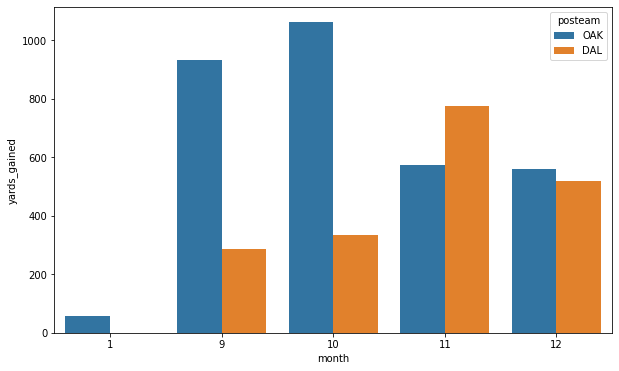

In [6]:
team_yards_in_a_month = coop_df.groupby(['month', 'posteam'], as_index = False)['yards_gained'].sum() \
    .sort_values(['month', 'posteam'])

plt.figure(figsize=(10,6))
sns.barplot(x= 'month', y = 'yards_gained', data=team_yards_in_a_month, hue='posteam')

In [7]:
team_games_in_a_month = coop_df.groupby(['month', 'posteam'], as_index=False)['game_id'] \
    .agg({'games': pd.Series.nunique}) \
    .sort_values(['month', 'posteam'])

graph_df = team_yards_in_a_month.merge(team_games_in_a_month, on = ['month', 'posteam'])

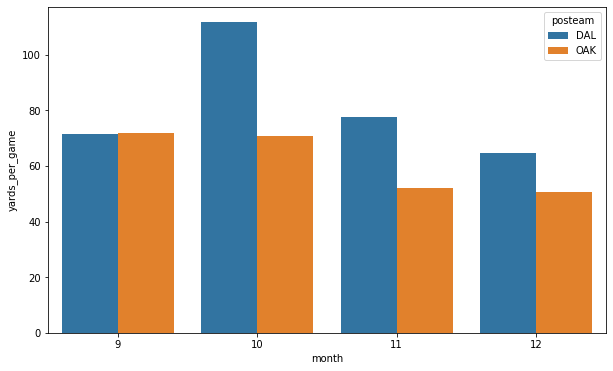

In [8]:
graph_df['yards_per_game'] = graph_df['yards_gained'] / graph_df['games']

plt.figure(figsize=(10,6))
sns.barplot(x='month', y='yards_per_game', hue='posteam', data=graph_df.loc[graph_df.month != 1])

In [9]:
# team_yards_in_a_qtr = coop_df.groupby(['qtr', 'posteam', 'month'], as_index = False)['yards_gained'].sum() \
#     .sort_values(['qtr', 'posteam'])

# sns.barplot(x='qtr', y='yards_gained', data=team_yards_in_a_qtr.loc[team_yards_in_a_qtr.qtr != 5], #hue='posteam'
#            )

# g = sns.FacetGrid(team_yards_in_a_qtr, col="qtr", col_wrap=2, height=1.5)
# g = g.map(plt.hist, "month", "yards_gained", marker=".")

In [10]:
def request_data(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    return soup

def get_team_data(bs_data):
    teams = bs_data.find_all(class_="team-name text-center")

    away_teams = []
    home_teams = []

    for i, v in enumerate(teams):
        if i % 2 == 0:
            away_teams.append(teams[i].find('a').contents[0])
        else:
            home_teams.append(teams[i].find('a').contents[0])
            
    return away_teams, home_teams

def get_weather_data(bs_data):
    games = bs_data.find_all('tr')

    weather_lst = []
    for i, v in enumerate(games):
        #skip header
        if i > 0:
            game_details = games[i].find_all(class_='text-center')

            forecast = game_details[5].contents[0]

            weather_lst.append(' '.join(forecast.split()))
            
    return weather_lst

In [11]:
weather_lst = []

for season in seasons:
    print(f'Scraping Weather Data for the {season} Season')
    for week in weeks:
        request_url = f'{weather_url}{season}/week-{week}'
        soup = request_data(request_url)
        
        away_teams, home_teams = get_team_data(soup)
        
        weather = get_weather_data(soup)
        
        weather_df = pd.DataFrame({'away_tm': away_teams,
                                   'home_tm': home_teams,
                                   'weather': weather,
                                  })
        
        weather_df['year'] = season
        weather_df['week'] = week
        
        weather_lst.append(weather_df)
        
full_weather_df = pd.concat(weather_lst).reset_index(drop=True)

coop_weather_df = full_weather_df.loc[(full_weather_df.away_tm.isin(['Cowboys','Raiders'])) |
                                      (full_weather_df.home_tm.isin(['Cowboys','Raiders']))]

Scraping Weather Data for the 2015 Season
Scraping Weather Data for the 2016 Season
Scraping Weather Data for the 2017 Season
Scraping Weather Data for the 2018 Season
Scraping Weather Data for the 2019 Season


In [19]:
coop_df = coop_df.replace('SD', 'LAC')
coop_df.shape

(586, 258)

In [20]:
coop_weather_df['away_team'] = coop_weather_df['away_tm'].apply(lambda x: team_map[x])
coop_weather_df['home_team'] = coop_weather_df['home_tm'].apply(lambda x: team_map[x])

In [21]:
merged_coop_df = coop_df.merge(coop_weather_df, how = 'left', on = ['away_team', 'home_team', 'year'])

In [36]:
merged_coop_df['temp'] = np.where(merged_coop_df.weather == 'DOME',
                                  -999,
                                  merged_coop_df.weather.str.split('f').str[0]).astype(int)

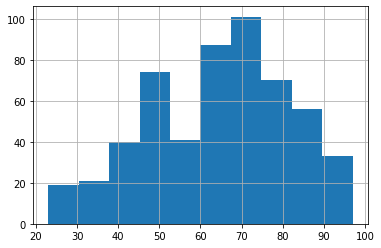

In [39]:
merged_coop_df.loc[merged_coop_df.weather != 'DOME']['temp'].hist()

In [ ]:
merged_coop_df.loc[merged_coop_df.weather != 'DOME']

In [46]:
merged_coop_df['temp_bin'] = np.where(merged_coop_df.temp < 50, "<50",
                                      np.where(merged_coop_df.temp < 75,'50-75',
                                      np.where(merged_coop_df.temp >= 75, '>=75', 'NO TEMP')))

In [49]:
merged_coop_df.temp_bin.value_counts(normalize=True)

50-75    0.450512
<50      0.278157
>=75     0.271331
Name: temp_bin, dtype: float64

In [79]:
temp_bin_df = merged_coop_df.groupby(['temp_bin'], as_index = False)['game_id',] \
    .agg(pd.Series.nunique) \
    .merge(merged_coop_df.groupby(['temp_bin'], as_index = False)['yards_gained',]
           .agg(np.sum), on = 'temp_bin')

In [82]:
temp_bin_df['yards_per_game'] = temp_bin_df['yards_gained'] / temp_bin_df['game_id']

In [84]:
temp_bin_df.sort_values('yards_per_game')

,temp_bin,game_id,yards_gained,yards_per_game
1,<50,22,1067,48.500000
0,50-75,36,2319,64.416667
2,>=75,19,1713,90.157895
